In [10]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
%matplotlib inline

In [2]:
data = gpd.read_file('AllData5/AllData5.shp')
data.head()

,ZIPCODE,2014_main,2013_main,2013_aux,COUNTY,2015_main,2012_total,2010_main,2014_total,2010_total,...,incomeChan,educationC,homevalue2,homevalu_1,rentvalue2,rentvalu_1,predFeatur,predictedC,predicted_,geometry
0,10001.0,158081.306253,147100.025839,29495.888233,New York,154839.319753,170271.223443,127396.025668,189201.340778,149992.497620,...,0.305691,3.771518,457982.163708,5.791209e+05,1427.204856,2005.557866,97378.623188,193259.638017,0.333712,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002.0,19097.528421,17311.940049,1721.605455,New York,21439.070402,20205.790472,17501.189156,21019.026500,18817.103810,...,0.059098,5.507709,574335.103350,6.518112e+05,1014.040468,1241.488130,5828.836996,11568.030961,0.017748,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003.0,64501.109568,62081.330388,10712.407074,New York,69158.840084,70059.871496,61530.840315,76009.878076,70894.659554,...,0.186879,1.521574,712312.942888,7.192630e+05,1606.919874,1940.590789,7125.046514,14140.515291,0.019660,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004.0,39238.790292,33490.618770,8178.384029,New York,41028.223248,43504.289005,30317.620752,48395.422181,37856.752472,...,0.088852,5.446526,797216.459596,9.333029e+05,NaN,NaN,5311.254643,10540.826273,0.011294,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10005.0,42550.105749,43517.336279,13375.093312,New York,43330.350179,61201.345346,49133.608421,54751.143544,62925.121081,...,0.020961,5.907278,874000.000000,1.035900e+06,NaN,NaN,5673.951613,11260.642212,0.010870,"POLYGON ((982595.6794779003 195880.7536295503,..."


In [3]:
data.columns


Index([   u'ZIPCODE',  u'2014_main',  u'2013_main',   u'2013_aux',
           u'COUNTY',  u'2015_main', u'2012_total',  u'2010_main',
       u'2014_total', u'2010_total',   u'2010_aux',   u'2014_aux',
        u'2012_main', u'2011_total', u'2015_total',  u'2011_main',
       u'2013_total',   u'2012_aux',   u'2015_aux',   u'2011_aux',
       u'2015_per_m',       u'rank',        u'top', u'rank_notMN',
        u'top_notMN',    u'top_all',          u'x',          u'y',
             u'CBDs',   u'Feature2',   u'Feature1', u'Feature201',
       u'Feature2_1', u'changeFeat', u'Unnamed_ 0', u'households',
       u'pctChange_', u'househol_1', u'pctChang_1', u'househol_2',
       u'incomeChan', u'educationC', u'homevalue2', u'homevalu_1',
       u'rentvalue2', u'rentvalu_1', u'predFeatur', u'predictedC',
       u'predicted_',   u'geometry'],
      dtype='object')

In [4]:
data.rename(columns={'Feature201':'Feature2015', 'Feature2_1':'Feature2010', 'changeFeat': 'changeFeature',
                     'homevalu_1':'homevalue2015', 'homevalue2':'homevalue2010', 'rentvalu_1':'rentvalue2015',
                     'rentvalue2':'rentvalue2010', 'predicted_':'predicted_perc', 'predictedC':'predictedValue'}, inplace=True)

### Jobs data and correcting for Downtown Brooklyn

In [5]:
dataJobs2 = gpd.read_file('nyc_cbds_final/nyc_cbds_final.shp')

In [6]:
dataJobs2.iloc[97, -1] = dataJobs2.loc[97, '2014_total'] - dataJobs2.loc[97, '2010_total']
dataJobs2.iloc[12, -1] = dataJobs2.loc[12, '2014_total'] - dataJobs2.loc[12, '2010_total']

### Getting the zips under 1 hour for each zip code and their times

#### Times data

In [7]:
times = pd.read_csv('AllZipsTimes.csv')
times.drop(columns={'Unnamed: 0'}, inplace=True)
times.head()

,ZIPCODE,10473,10474,10475,11001,11004,11005,11040,11096,11101,...,11426,11427,11428,11429,11430,11432,11433,11434,11435,11436
0,10001.0,68,51,74,80,88,92,87,66,23,...,70,63,48,54,68,51,47,61,30,48
1,10002.0,73,70,70,101,98,105,96,89,30,...,89,83,70,73,93,58,67,76,54,77
2,10003.0,72,53,57,87,76,99,85,84,27,...,80,70,65,69,86,54,65,80,54,75
3,10004.0,72,58,63,103,104,110,87,74,31,...,87,70,66,69,89,63,74,64,61,83
4,10005.0,74,58,63,103,99,110,83,78,31,...,87,63,59,62,87,62,73,50,41,82


In [8]:
zipsUnderHour = {zips:[] for zips in data['ZIPCODE']}
zipsUnderHourTimes = {zips:[] for zips in data['ZIPCODE']}

In [12]:
for i in range(len(data)):

    for cols in times.columns[1:]:
        
        if type(times[cols][i]) == np.int64:
            
            if times[cols][i] < 60:
                zipsUnderHour[times.ZIPCODE[i]].append(cols)
                zipsUnderHourTimes[times.ZIPCODE[i]].append(times[cols][i])

KeyError: 10041.0

### Calculating a feature 'Feature2015' for every zip code. All other features are calculated similarly

In [ ]:
zipsFeatures2015 = {zips:[] for zips in data['ZIPCODE']}

for key, value in zipsUnderHour.iteritems():
    print value
    feature = 0.0
    for i, val in enumerate(value):
        #print val
        change = dataJobs2.loc[dataJobs2.ZIPCODE == int(val), '2015_total']
        #print change.values[0]
        time = zipsUnderHourTimes.get(key)[i]
        if time == 0:
            time = 1
        #print type(change)
        if len(change) != 0 and ~np.isnan(change.values[0]):

            feature = feature + float(change.values[0])/float(time)
        else:
            pass
        
    zipsFeatures2015[key] = feature

## Predicting
### For prediction, we need the new features for all zips assuming the change in jobs for all other zips than the below zips 0. Thus instead of calculating the feature itself, we calculated the change in the feature for all zip codes so that for prediction, we will get the change in home values.

In [ ]:
NewJobs = {11101:25000, 10001:95752, 10017:11333}

In [ ]:
Change = {zips:[] for zips in data['ZIPCODE']}

for key, value in zipsUnderHour.iteritems():
    print value
    feature = 0.0
    for i, val in enumerate(value):
        #print val
        if int(val) in NewJobs.keys():
            change = NewJobs.get(int(val))
        else:
            change = 0
        #print change.values[0]
        time = zipsUnderHourTimes.get(key)[i]
        if time == 0:
            time = 1
        #print type(change)
        #if len(change) != 0 and ~np.isnan(change.values[0]):

        feature = feature + float(change)/float(time)
        
        #else:
        #    pass
        
    Change[key] = feature

### Finally the change is calculated by multiplying the change in feature with the coefficient of the trained OLS model

In [9]:
ols1 = smf.ols('homevalue2015 ~ Feature2015', data=data).fit()
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          homevalue2015   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     121.7
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           6.34e-22
Time:                        14:44:15   Log-Likelihood:                -2417.2
No. Observations:                 181   AIC:                             4838.
Df Residuals:                     179   BIC:                             4845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.874e+05   1.81e+04     21.354      0.000    3.52e+05    4.23e+05
Feature2015     1.9846      0.180     11.033      0.000       1.630       2.340
==============================================================================
Omnibus:                       16.637   Durbin-Watson:                   1.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.330
Skew:                           0.561   Prob(JB):                     8.59e-06
Kurtosis:                       4.354   Cond. No.                     1.60e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
predictedValue = data.predFeature*ols1.params[1]

In [5]:
data.head()

,ZIPCODE,2014_main,2013_main,2013_aux,COUNTY,2015_main,2012_total,2010_main,2014_total,2010_total,...,incomeChan,educationC,homevalue2010,homevalue2015,rentvalue2010,rentvalue2015,predFeatur,predictedValue,predicted_perc,geometry
0,10001.0,158081.306253,147100.025839,29495.888233,New York,154839.319753,170271.223443,127396.025668,189201.340778,149992.497620,...,0.305691,3.771518,457982.163708,5.791209e+05,1427.204856,2005.557866,97378.623188,193259.638017,0.333712,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002.0,19097.528421,17311.940049,1721.605455,New York,21439.070402,20205.790472,17501.189156,21019.026500,18817.103810,...,0.059098,5.507709,574335.103350,6.518112e+05,1014.040468,1241.488130,5828.836996,11568.030961,0.017748,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003.0,64501.109568,62081.330388,10712.407074,New York,69158.840084,70059.871496,61530.840315,76009.878076,70894.659554,...,0.186879,1.521574,712312.942888,7.192630e+05,1606.919874,1940.590789,7125.046514,14140.515291,0.019660,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004.0,39238.790292,33490.618770,8178.384029,New York,41028.223248,43504.289005,30317.620752,48395.422181,37856.752472,...,0.088852,5.446526,797216.459596,9.333029e+05,NaN,NaN,5311.254643,10540.826273,0.011294,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10005.0,42550.105749,43517.336279,13375.093312,New York,43330.350179,61201.345346,49133.608421,54751.143544,62925.121081,...,0.020961,5.907278,874000.000000,1.035900e+06,NaN,NaN,5673.951613,11260.642212,0.010870,"POLYGON ((982595.6794779003 195880.7536295503,..."


/anaconda2/lib/python2.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


Text(0.5,1,'Predicted home value')

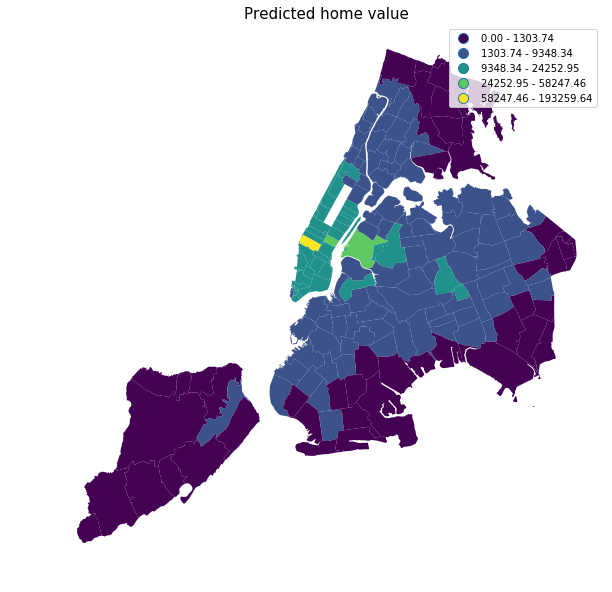

In [6]:
ax = data.plot(column='predictedValue', figsize=(10,10), legend=True, scheme='fisher_jenks', k=5)
ax.set_axis_off()
plt.title('Predicted home value', fontsize=15)

Text(0.5,1,'Predicted percentage change in home value')

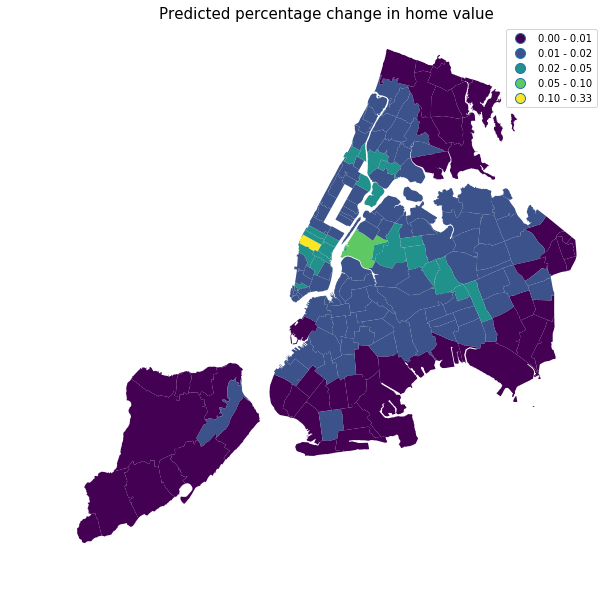

In [7]:
ax = data[~data.predicted_perc.isna()].plot(column='predicted_perc', figsize=(10,10), legend=True, scheme='fisher_jenks', k=5)
ax.set_axis_off()
plt.title('Predicted percentage change in home value', fontsize=15)

In [26]:
ols1 = smf.ols('homevalue2015 ~ Feature2015', data=data).fit()
ols1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          homevalue2015   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     121.7
Date:                Thu, 13 Dec 2018   Prob (F-statistic):           6.34e-22
Time:                        19:04:15   Log-Likelihood:                -2417.2
No. Observations:                 181   AIC:                             4838.
Df Residuals:                     179   BIC:                             4845.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.874e+05   1.81e+04     21.354      0.000    3.52e+05    4.23e+05
Feature2015     1.9846      0.180     11.033      0.000       1.630       2.340
==============================================================================
Omnibus:                       16.637   Durbin-Watson:                   1.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.330
Skew:                           0.561   Prob(JB):                     8.59e-06
Kurtosis:                       4.354   Cond. No.                     1.60e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
ols2 = smf.ols('rentvalue2015 ~ Feature2015', data=data).fit()
ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          rentvalue2015   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     42.49
Date:                Thu, 13 Dec 2018   Prob (F-statistic):           7.40e-10
Time:                        19:04:47   Log-Likelihood:                -1244.6
No. Observations:                 176   AIC:                             2493.
Df Residuals:                     174   BIC:                             2500.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1209.1143     34.045     35.516      0.000    1141.921    1276.308
Feature2015     0.0023      0.000      6.519      0.000       0.002       0.003
==============================================================================
Omnibus:                        0.926   Durbin-Watson:                   1.083
Prob(Omnibus):                  0.629   Jarque-Bera (JB):                0.646
Skew:                           0.133   Prob(JB):                        0.724
Kurtosis:                       3.133   Cond. No.                     1.55e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5,1,'Home values (2015) vs Feature2015')

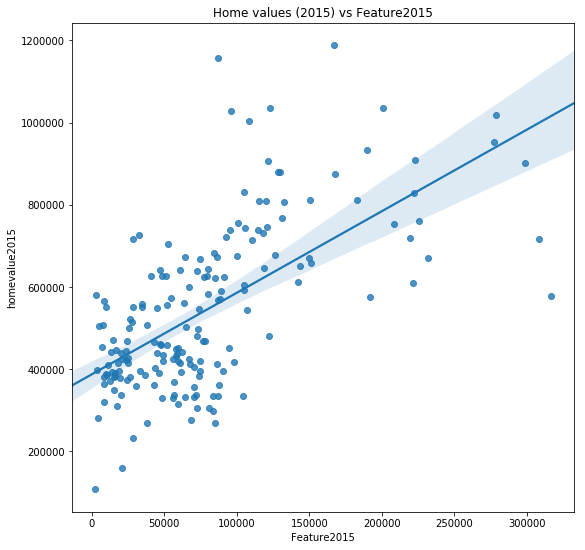

In [32]:
plt.figure(figsize=(9,9))
sns.regplot(x='Feature2015', y='homevalue2015', data=data)
plt.title('Home values (2015) vs Feature2015')